In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [2]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)
# sales_data

In [3]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [4]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [5]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [6]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [7]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category4

# Remove Outliers

In [23]:
def remove_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(30)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [24]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

# Adding Lagged Variables

In [25]:
lags = [1,2,3]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3']
category = category[selected_columns]

# Standardization

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(category.drop(category.columns[0], axis=1))
y = scaler.fit_transform(np.array(category.iloc[:,0]).reshape(-1, 1))

# PCA

In [27]:
n_components = len(lags)
pca = PCA(n_components=n_components)
X = pca.fit_transform(X)

# Train - Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [52]:
# len(X_train)
len(X_test)
# len(X_val)

6

# Reshape for LSTM input

In [30]:
X_train_scaled_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_scaled_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
# X_val_scaled_reshaped = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Fit the model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

In [32]:
model = Sequential()
model.add(LSTM(units=550, return_sequences=True, kernel_regularizer=L2(0.07),activation='tanh', input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])))
model.add(LSTM(units=250, kernel_regularizer=L2(0.07), activation='tanh'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [33]:
cp = ModelCheckpoint('Models Pickled Flies/Sales Day Prediction Model(PCA and Standardization)/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics = [RootMeanSquaredError()])

In [44]:
model.fit(X_train_scaled_reshaped, y_train, epochs=150, callbacks=[cp])

Epoch 1/150
1/1 [==============================] - 0s 138ms/step - loss: 0.7494 - root_mean_squared_error: 0.8477
Epoch 2/150
1/1 [==============================] - 0s 148ms/step - loss: 0.7487 - root_mean_squared_error: 0.8469
Epoch 3/150
1/1 [==============================] - 0s 137ms/step - loss: 0.7477 - root_mean_squared_error: 0.8460
Epoch 4/150
1/1 [==============================] - 0s 134ms/step - loss: 0.7462 - root_mean_squared_error: 0.8447
Epoch 5/150
1/1 [==============================] - 0s 136ms/step - loss: 0.7448 - root_mean_squared_error: 0.8436
Epoch 6/150
1/1 [==============================] - 0s 145ms/step - loss: 0.7440 - root_mean_squared_error: 0.8426
Epoch 7/150
1/1 [==============================] - 0s 153ms/step - loss: 0.7431 - root_mean_squared_error: 0.8417
Epoch 8/150
1/1 [==============================] - 0s 129ms/step - loss: 0.7417 - root_mean_squared_error: 0.8405
Epoch 9/150
1/1 [==============================] - 0s 123ms/step - loss: 0.7404 - root_m

1/1 [==============================] - 0s 126ms/step - loss: 0.7275 - root_mean_squared_error: 0.8267
Epoch 30/150
1/1 [==============================] - 0s 122ms/step - loss: 0.7236 - root_mean_squared_error: 0.8244
Epoch 31/150
1/1 [==============================] - 0s 118ms/step - loss: 0.7258 - root_mean_squared_error: 0.8257
Epoch 32/150
1/1 [==============================] - 0s 113ms/step - loss: 0.7258 - root_mean_squared_error: 0.8258
Epoch 33/150
1/1 [==============================] - 0s 114ms/step - loss: 0.7222 - root_mean_squared_error: 0.8238
Epoch 34/150
1/1 [==============================] - 0s 117ms/step - loss: 0.7231 - root_mean_squared_error: 0.8244
Epoch 35/150
1/1 [==============================] - 0s 112ms/step - loss: 0.7237 - root_mean_squared_error: 0.8249
Epoch 36/150
1/1 [==============================] - 0s 115ms/step - loss: 0.7209 - root_mean_squared_error: 0.8232
Epoch 37/150
1/1 [==============================] - 0s 107ms/step - loss: 0.7210 - root_mean_

Epoch 58/150
1/1 [==============================] - 0s 116ms/step - loss: 0.7108 - root_mean_squared_error: 0.8189
Epoch 59/150
1/1 [==============================] - 0s 107ms/step - loss: 0.7106 - root_mean_squared_error: 0.8189
Epoch 60/150
1/1 [==============================] - 0s 104ms/step - loss: 0.7104 - root_mean_squared_error: 0.8189
Epoch 61/150
1/1 [==============================] - 0s 111ms/step - loss: 0.7100 - root_mean_squared_error: 0.8187
Epoch 62/150
1/1 [==============================] - 0s 110ms/step - loss: 0.7094 - root_mean_squared_error: 0.8185
Epoch 63/150
1/1 [==============================] - 0s 110ms/step - loss: 0.7089 - root_mean_squared_error: 0.8182
Epoch 64/150
1/1 [==============================] - 0s 133ms/step - loss: 0.7084 - root_mean_squared_error: 0.8180
Epoch 65/150
1/1 [==============================] - 0s 112ms/step - loss: 0.7081 - root_mean_squared_error: 0.8180
Epoch 66/150
1/1 [==============================] - 0s 114ms/step - loss: 0.7079

1/1 [==============================] - 0s 118ms/step - loss: 0.7019 - root_mean_squared_error: 0.8161
Epoch 87/150
1/1 [==============================] - 0s 119ms/step - loss: 0.7024 - root_mean_squared_error: 0.8165
Epoch 88/150
1/1 [==============================] - 0s 117ms/step - loss: 0.7026 - root_mean_squared_error: 0.8166
Epoch 89/150
1/1 [==============================] - 0s 111ms/step - loss: 0.7023 - root_mean_squared_error: 0.8166
Epoch 90/150
1/1 [==============================] - 0s 108ms/step - loss: 0.7015 - root_mean_squared_error: 0.8161
Epoch 91/150
1/1 [==============================] - 0s 113ms/step - loss: 0.7007 - root_mean_squared_error: 0.8157
Epoch 92/150
1/1 [==============================] - 0s 120ms/step - loss: 0.7002 - root_mean_squared_error: 0.8155
Epoch 93/150
1/1 [==============================] - 0s 120ms/step - loss: 0.7002 - root_mean_squared_error: 0.8155
Epoch 94/150
1/1 [==============================] - 0s 116ms/step - loss: 0.7003 - root_mean_

1/1 [==============================] - 0s 120ms/step - loss: 0.7093 - root_mean_squared_error: 0.8222
Epoch 115/150
1/1 [==============================] - 0s 116ms/step - loss: 0.7007 - root_mean_squared_error: 0.8171
Epoch 116/150
1/1 [==============================] - 0s 128ms/step - loss: 0.6961 - root_mean_squared_error: 0.8143
Epoch 117/150
1/1 [==============================] - 0s 117ms/step - loss: 0.7014 - root_mean_squared_error: 0.8175
Epoch 118/150
1/1 [==============================] - 0s 109ms/step - loss: 0.7032 - root_mean_squared_error: 0.8187
Epoch 119/150
1/1 [==============================] - 0s 105ms/step - loss: 0.6971 - root_mean_squared_error: 0.8150
Epoch 120/150
1/1 [==============================] - 0s 126ms/step - loss: 0.6967 - root_mean_squared_error: 0.8148
Epoch 121/150
1/1 [==============================] - 0s 110ms/step - loss: 0.7007 - root_mean_squared_error: 0.8173
Epoch 122/150
1/1 [==============================] - 0s 118ms/step - loss: 0.6979 - ro

1/1 [==============================] - 0s 125ms/step - loss: 0.6935 - root_mean_squared_error: 0.8133
Epoch 143/150
1/1 [==============================] - 0s 117ms/step - loss: 0.6934 - root_mean_squared_error: 0.8133
Epoch 144/150
1/1 [==============================] - 0s 112ms/step - loss: 0.6937 - root_mean_squared_error: 0.8136
Epoch 145/150
1/1 [==============================] - 0s 127ms/step - loss: 0.6934 - root_mean_squared_error: 0.8134
Epoch 146/150
1/1 [==============================] - 0s 111ms/step - loss: 0.6930 - root_mean_squared_error: 0.8132
Epoch 147/150
1/1 [==============================] - 0s 128ms/step - loss: 0.6931 - root_mean_squared_error: 0.8133
Epoch 148/150
1/1 [==============================] - 0s 111ms/step - loss: 0.6932 - root_mean_squared_error: 0.8133
Epoch 149/150
1/1 [==============================] - 0s 114ms/step - loss: 0.6929 - root_mean_squared_error: 0.8132
Epoch 150/150
1/1 [==============================] - 0s 109ms/step - loss: 0.6926 - ro

# Evaluate Model

In [45]:
# from tensorflow.keras.models import load_model
# pickledModel = load_model('Models Pickled Flies/Expenses Day Prediction Model(PCA and Standardization)/')

In [46]:
mse = model.evaluate(X_train_scaled_reshaped, y_train, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [0.6926703453063965, 0.8131200671195984]


In [47]:
mse = model.evaluate(X_test_scaled_reshaped, y_test, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [0.7639053463935852, 0.8558032512664795]


In [48]:
# mse = model.evaluate(X_val_scaled_reshaped, y_val, verbose=0)
# print(f'Mean Squared Error is {mse}')

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [49]:
train_predictions = model.predict(X_train_scaled_reshaped)
predictions = scaler.inverse_transform(train_predictions).flatten()

1/1 [==============================] - 0s 198ms/step


In [50]:
index_start = 3
index = range(index_start, index_start + len(predictions))
df = pd.DataFrame(predictions, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

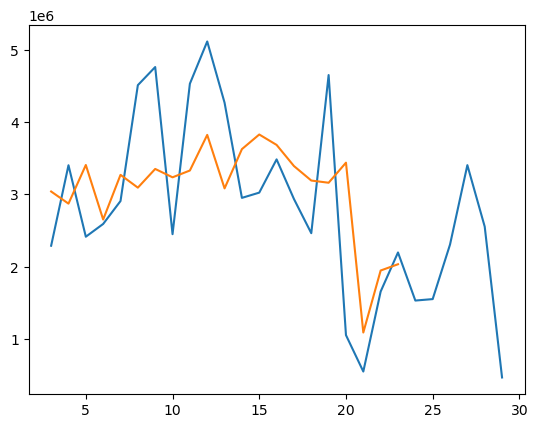

In [51]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel

# Make Time Series Predictions

In [96]:
predictions = model.predict(X_test_scaled_reshaped)

1/1 [==============================] - 0s 105ms/step
